# ARIMA Model in Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize

pd.set_option('display.max_rows', 500)

In [2]:
# parser for dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [3]:
def adf_check(time_series):
    result = adfuller(time_series.dropna())
    print('Augmented Dickey-Fuller Test:')
    print(f"p-value : {result[1]}")
    
    if result[1] < 0.05:
        print("p-value < 0.05. Data is stationary")
    else:
        print("p-value >= 0.05. Data is non-stationary")

In [4]:
data = pd.read_csv("shampoo.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
first_diff_data = data.diff() # difference the data once

<AxesSubplot:xlabel='Month'>

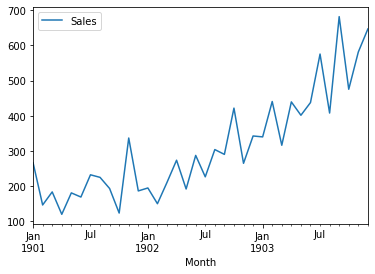

In [5]:
data.plot()

<AxesSubplot:xlabel='Month'>

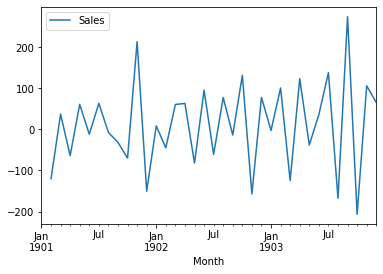

In [6]:
first_diff_data.plot()

In [7]:
adf_check(data)

Augmented Dickey-Fuller Test:
p-value : 1.0
p-value >= 0.05. Data is non-stationary


In [8]:
adf_check(first_diff_data)

Augmented Dickey-Fuller Test:
p-value : 1.7998574141687034e-10
p-value < 0.05. Data is stationary


/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


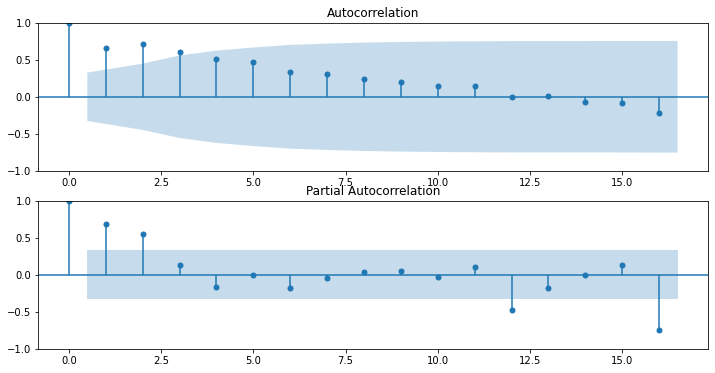

In [9]:
# ACF and PACF of undifferenced data
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(data.dropna(), ax=ax[1], lags=16)
# plt.savefig("acf_pacf_data", bbox_inches="tight")
plt.show()

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


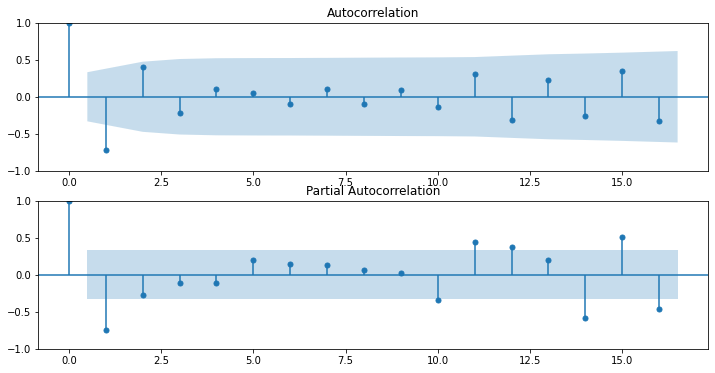

In [10]:
# ACF and PACF of differenced data
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(first_diff_data.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(first_diff_data.dropna(), ax=ax[1], lags=16)
# plt.savefig("acf_pacf_first", bbox_inches="tight")
plt.show()

In [11]:
def generate_AR(params, y):
    p = len(params)
    preds = []
    errors = []
    for t in range(len(y)):
        pred = 0
        if t > p:
            for i in range(p):
                pred += params[i] * y.iloc[t-i-1]

        # append the prediction and error
        preds.append(pred)
        errors.append(y[t] - pred)
    errors = pd.Series(errors, index=y.index)
    preds = pd.Series(preds, index=y.index)
    return errors, preds

In [12]:
def AR_param_estimate(params, y):
    errors, preds = generate_AR(params, y)
    return np.sum(errors**2)

In [13]:
def generate_MA(params, y):
    q = len(params)
    preds = []
    errors = []
    for t in range(len(y)):
        pred = 0
        if t > q:
            for i in range(q):
                pred += params[i] * errors[t-i-1]

        # append the prediction and error 
        preds.append(pred)
        errors.append(y[t] - pred)
    errors = pd.Series(errors, index=y.index)
    preds = pd.Series(preds, index=y.index)
    return errors, preds

In [14]:
def MA_param_estimate(params, y):
    errors, preds = generate_MA(params, y)
    return np.sum(errors**2)

In [15]:
def myARIMA(data_series, p, d, q):
    if d > 1:
        raise Exception("Cannot handle d > 1")
        
    ar_coefs = None
    ma_coefs = None
    data_series = data_series.asfreq('MS')
    
    data = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])

    # difference the series according to parameter d
    data["Diff"] = data["original"]
    for _ in range(d):
        data["Diff"] = data["Diff"].diff()

    mu = data["Diff"].mean() # average of the period to period change
    data["Diff"] = data["Diff"].fillna(0)
    
    # set up AR terms with the differenced series
    ar = pd.DataFrame((data["Diff"]).values, index=data.index, columns=["original"])
    if p == 0:
        ar["predicted"] = 0
    else:
        y = ar["original"]
        # AR (phi) constraints
        cons = [
            {
                'type': 'ineq',
                'fun': lambda x: x[-1] + 1
            },
            {
                'type': 'ineq',
                'fun': lambda x: 1 - x[-1]
            },
        ] + [{'type': 'ineq', 'fun': lambda x: 1 - x[i] - x[i+1]} for i in range(p-1)] + [{'type': 'ineq', 'fun': lambda x: 1 + x[i] - x[i+1]} for i in range(p-1)]
        ar_coefs = minimize(AR_param_estimate, [1]*p, method="COBYLA", constraints=cons, args=(y,)).x
        errors, preds = generate_AR(ar_coefs, y)
        ar["predicted"] = preds
    
    data["AR_predicted"] = ar["predicted"]

    # Set up MA component with error terms
    ma = pd.DataFrame(ar["original"] - ar["predicted"], index=data.index, columns=["original"])
    ma["error"] = ma["original"]
    if q == 0:
        ma["predicted"] = 0
    else:
        y = ma["original"]
        # MA (theta) constraints
        cons = [
            {
                'type': 'ineq',
                'fun': lambda x: x[-1] + 1
            },
            {
                'type': 'ineq',
                'fun': lambda x: 1 - x[-1]
            },
        ] + [{'type': 'ineq', 'fun': lambda x: 1 - x[i] - x[i+1]} for i in range(q-1)] + [{'type': 'ineq', 'fun': lambda x: 1 + x[i] - x[i+1]} for i in range(q-1)]
        ma_coefs = minimize(MA_param_estimate, [1]*q, method="COBYLA", constraints=cons, args=(y,)).x
        errors, preds = generate_MA(ma_coefs, y)
        ma["predicted"] = preds
        ma["error"] = errors

    data["MA_predicted"] = ma["predicted"]

    # Put the data back together
    if d == 0:
        data["predicted"] = mu + data["AR_predicted"] + data["MA_predicted"]
    else:
        data["predicted"] = data["original"].shift() + mu + data["AR_predicted"] + data["MA_predicted"]
    data = data.fillna(0)

    # new dataframe for forecasts
    forecast = pd.DataFrame()
    forecast["original"] = data["original"]
    forecast["full_data"] = data["original"]
    forecast["predicted"] = data["predicted"]
    forecast["residuals"] = ma["error"]
    forecast["forecast"] = np.NaN
    # print(forecast)

    # forecast 15 timesteps ahead
    for i in range(15):
        ar_forecast = 0
        if p > 0:
            if d == 0:
                # if no differencing then sum up coefficient with associated data point
                for i in range(1, p+1):
                    ar_forecast += ar_coefs[i-1] * forecast.iloc[-i]["full_data"]
            else:
                # compute AR component of forecast accounting for 1 order of differencing
                first_ar = (1 + ar_coefs[0]) * forecast.iloc[-1]["full_data"]
                middle_ar = 0
                for lag in range(1, p):
                    middle_ar += (ar_coefs[lag] - ar_coefs[lag-1]) * forecast.iloc[-lag-1]["full_data"]
                last_ar = ar_coefs[-1] * forecast.iloc[-p-1]["full_data"]
                ar_forecast = first_ar + middle_ar - last_ar
        else:
            if d == 0:
                ar_forecast = 0
            else:
                ar_forecast = forecast.iloc[-1]["full_data"]
        # print(first_ar, middle_ar, last_ar)

        ma_forecast = 0
        if q > 0:
            for i in range(len(ma_coefs)):
                ma_forecast += ma_coefs[i] * forecast.iloc[-i-1]["residuals"]
                
        prediction = mu + ar_forecast + ma_forecast
        next_time = forecast.index[-1] + forecast.index.freq
        # adding to columns [original, full_data, predicted, residuals, forecast]
        forecast.loc[next_time] = [np.NaN, prediction, np.NaN, 0, prediction]
        forecast = forecast.asfreq('MS')

    # plot our data

    # AR fit on differenced data
    ar[["original", "predicted"]].plot()
    plt.show()

    # density of errors
    ma[["error"]].plot(kind="kde")
    # plt.savefig(f"residuals2", bbox_inches="tight")
    plt.show()

    # MA fit on error terms
    ma[["error", "predicted"]].plot()
    plt.show()
    
    # ARIMA fit on original data
    data[["original", "predicted"]].plot()
    # plt.savefig(f"ARIMA_{p}{d}{q}", bbox_inches="tight")
    plt.show()

    # original data with forcasts
    forecast[["original", "forecast"]].plot(color=["C0", "green"])
    # plt.savefig(f"forecast_ARIMA_{p}{d}{q}", bbox_inches="tight")
    plt.show()

    print(f"{mu = }")
    print(f"{ar_coefs = }")
    print(f"{ma_coefs = }")

    #return forecast, ar_coefs, ma_coefs, ar, ma, mu



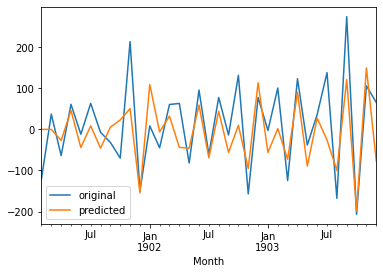

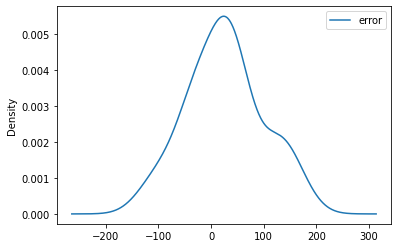

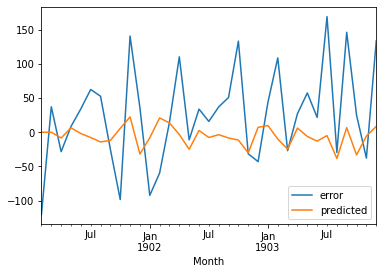

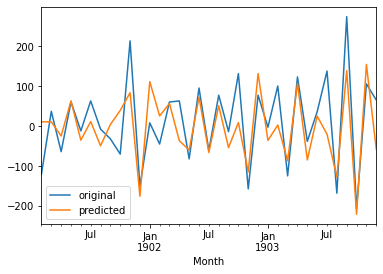

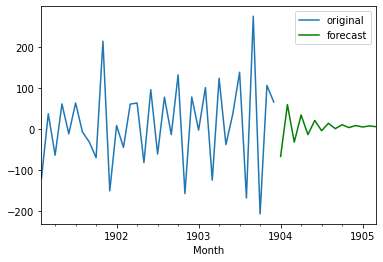

mu = 10.882857142857144
ar_coefs = array([-0.72333281])
ma_coefs = array([-0.22685078])


In [16]:
p, q = 1, 1 # change these values
myARIMA(first_diff_data.dropna(), p,0,q)

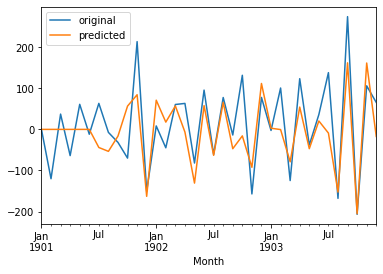

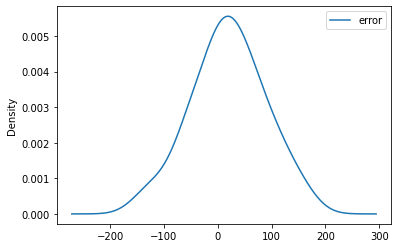

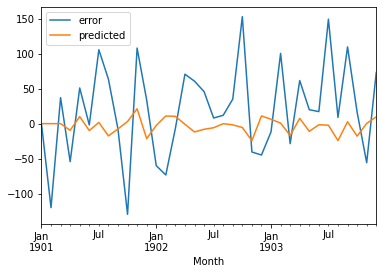

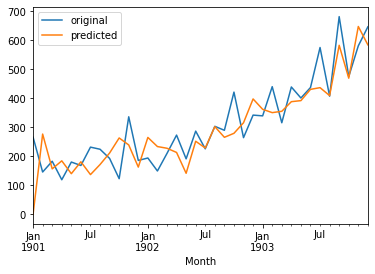

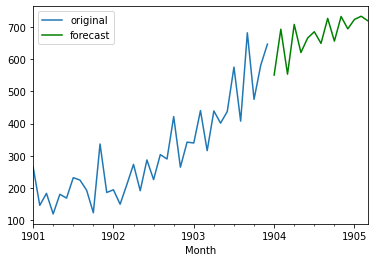

mu = 10.882857142857143
ar_coefs = array([-0.9257497 , -0.23467622,  0.09837658,  0.27293758,  0.37103817])
ma_coefs = array([-0.16530326,  0.02782006])


In [17]:
p, q = 5,2 # change these values
myARIMA(data, p,1,q)